In [1]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision.transforms import Normalize
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc

import warnings
warnings.filterwarnings('ignore')



In [2]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
test_dataset = torchvision.datasets.FashionMNIST(root='./datasets', train=False,  download=True, transform=transformer)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, pin_memory=True)

In [3]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.relu_1 = torch.nn.ReLU()
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.relu_2 = torch.nn.ReLU()
        self.fc_1 = torch.nn.Linear(256, 120)
        self.relu_3 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(120, 84)
        self.relu_4 = torch.nn.ReLU()
        self.fc_3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Normal Training LeNet

In [6]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model = LeNet().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [7]:
def evaluate_model(model, data, device):
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for x_batch, y_batch in data:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = torch.cat([logits, model(x_batch)])
            targets = torch.cat([targets, y_batch])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [8]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
print(f"Test accuracy for LeNet Normal is: {(100 * test_acc):.2f}%")

Test accuracy for LeNet Normal is: 88.91%


In [9]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [10]:
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()


In [11]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

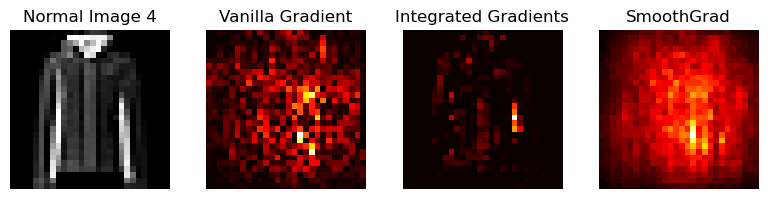

In [12]:
index = 6
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")
plt.tight_layout()
plt.savefig('Explanations/lenet_normal.png')

plt.show()


# Adversarial Training LeNet

In [14]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_adv = LeNet().to(device)
model_adv.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [15]:
# Model to GPU and eval mode.
model_adv.to(device)
model_adv.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_adv, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for LeNet Adversarial is: {(100 * test_acc):.2f}%")

Test accuracy for LeNet Adversarial is: 87.97%


In [20]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [23]:
a_batch_integrad_adv = IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()


In [24]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

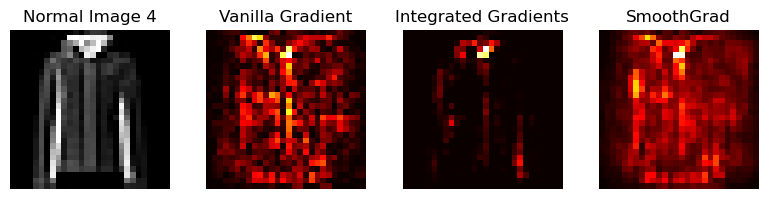

In [25]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_adv[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_adv[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_adv[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")
plt.tight_layout()
plt.savefig('Explanations/lenet_adversarial.png')

plt.show()

# Puning L1 Unstructured LeNet

In [29]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist_l1_unstructured.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_l1_unstructured = LeNet().to(device)

for name, module in model_l1_unstructured.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)
        
model_l1_unstructured.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [34]:
# Model to GPU and eval mode.
model_l1_unstructured.to(device)
model_l1_unstructured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_l1_unstructured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for LeNet Pruned L1 UnStructure is: {(100 * test_acc):.2f}%")

Test accuracy for LeNet Pruned L1 UnStructure is: 88.95%


In [35]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [36]:
a_batch_integrad_l1 = IntegratedGradients(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_l1[a_batch_integrad_l1<0] = 0
a_batch_saliency_l1 = Saliency(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_l1_unstructured)
a_batch_smoothgrad_l1 = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()


In [37]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

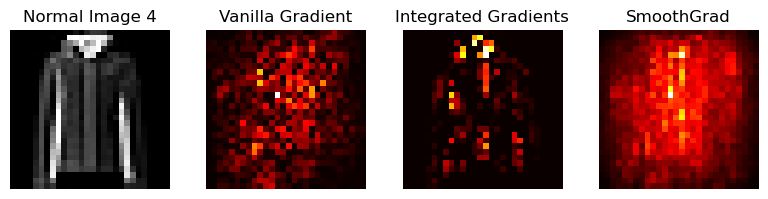

In [42]:
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_l1[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_l1[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_l1[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")
plt.tight_layout()

plt.savefig('Explanations/lenet_l1_unstructured.png')
plt.show()

# Pruning Global LeNet

In [48]:
def compute_sparsity(model):
    conv1_sparsity = torch.sum(model.conv_1.weight == 0) 
    conv2_sparsity = torch.sum(model.conv_2.weight == 0)
    fc1_sparsity = torch.sum(model.fc_1.weight == 0) 
    fc2_sparsity = torch.sum(model.fc_2.weight == 0) 
    fc3_sparsity = torch.sum(model.fc_3.weight == 0) 

    num = conv1_sparsity + conv2_sparsity +fc1_sparsity + fc2_sparsity + fc3_sparsity
    denom = model.conv_1.weight.nelement() + model.conv_2.weight.nelement() + model.fc_1.weight.nelement() + model.fc_2.weight.nelement() + model.fc_3.weight.nelement()

    global_sparsity = num/denom * 100

    return global_sparsity

In [51]:
from pathlib import Path

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist_global.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_global = LeNet().to(device)

parameters_to_prune = (
    (model_global.conv_1, 'weight'),
    (model_global.conv_2, 'weight'),
    (model_global.fc_1, 'weight'),
    (model_global.fc_2, 'weight'),
    (model_global.fc_3, 'weight')
)

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"LeNet-5 global sparsity = {compute_sparsity(model_global):.2f}%")

        
model_global.load_state_dict(torch.load(MODEL_SAVE_PATH))



Iterative Global pruning round = 1
LeNet-5 global sparsity = 20.00%


<All keys matched successfully>

In [55]:
# Model to GPU and eval mode.
model_global.to(device)
model_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_global, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for LeNet Pruned Global is: {(100 * test_acc):.2f}%")

Test accuracy for LeNet Pruned Global is: 89.47%


In [56]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [57]:
a_batch_integrad_global = IntegratedGradients(model_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_global[a_batch_integrad_global<0] = 0
a_batch_saliency_global =Saliency(model_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_global)
a_batch_smoothgrad_global = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

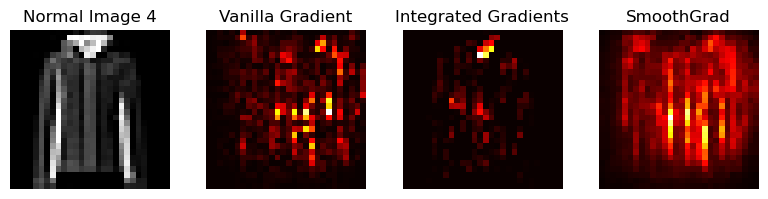

In [58]:
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_global[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_global[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_global[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")
plt.tight_layout()
plt.savefig('Explanations/lenet_global.png')

plt.show()

# Pruning Layered Strutured LeNet

In [64]:
def count_params(model):
    total_parameters = 0
    for layer, param in model.named_parameters():
        total_parameters += torch.count_nonzero(param.data)
    return total_parameters

In [66]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist_structured.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_structured = LeNet().to(device)

# # Prune layer-wise in a structured manner-
prune.ln_structured(model_structured.conv_1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.conv_2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.fc_1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.fc_2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.fc_3, name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"LeNet-5 global sparsity = {compute_sparsity(model_structured):.2f}%")

model_structured.load_state_dict(torch.load(MODEL_SAVE_PATH))


LeNet-5 global sparsity = 10.05%


<All keys matched successfully>

In [68]:
new_params = count_params(model_structured)
print(f"Pruned LeNet-5 model has {new_params} trainable parameters")

Pruned LeNet-5 model has 44426 trainable parameters


In [70]:
# Model to GPU and eval mode.
model_structured.to(device)
model_structured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_structured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for LeNet Pruned Layered Structure is: {(100 * test_acc):.2f}%")

Test accuracy for LeNet Pruned Layered Structure is: 85.99%


In [71]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [72]:
a_batch_integrad_structured = IntegratedGradients(model_structured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_structured[a_batch_integrad_structured<0] = 0
a_batch_saliency_structured = Saliency(model_structured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_structured)
a_batch_smoothgrad_structured = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

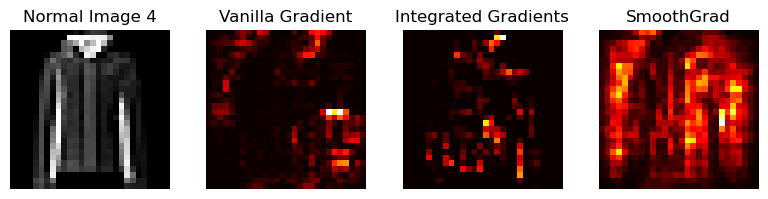

In [76]:
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*4., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_structured[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_structured[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_structured[index], cmap="hot")
axes[3].title.set_text(f"SmoothGrad")
axes[3].axis("off")
plt.tight_layout()
plt.savefig('Explanations/lenet_layered_structure.png')

plt.show()

# Quantitative Metrics

In [79]:
def explainer_wrapper(**kwargs):
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")

def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 1),kwargs.get("img_size", 28),kwargs.get("img_size", 28),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 28),
                kwargs.get("img_size", 28),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        )
    saliency = Saliency(model)
    
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


# # # SmoothGrad
# gc.collect()
# torch.cuda.empty_cache()
# a_batch_smoothgrad_custom = smoothgrad_explainer(model=model.to(device), 
#                                         inputs=x_batch, 
#                                         targets=y_batch,
#                                         **{ "device": device})

# gc.collect()
# torch.cuda.empty_cache()
# a_batch_smoothgrad_adv_custom = smoothgrad_explainer(model=model_adv.to(device), 
#                                         inputs=x_batch, 
#                                         targets=y_batch,
#                                         **{ "device": device})


In [81]:
xai_method=["SmoothGrad"]

In [128]:
def filter_and_compute_road_saliency_ig(model, test_loader, method, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain,
                explain_func_kwargs = {"method": method, "softmax": False})
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 1000:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts
    return average_values


In [130]:
result_normal = filter_and_compute_road_saliency_ig(model, test_dataloader, "Saliency", device)

In [131]:
result_adv = filter_and_compute_road_saliency_ig(model_adv, test_dataloader,"Saliency", device)

In [132]:
result_l1 = filter_and_compute_road_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)

In [133]:
result_global = filter_and_compute_road_saliency_ig(model_global, test_dataloader,"Saliency", device)

In [134]:
result_structured = filter_and_compute_road_saliency_ig(model_structured, test_dataloader,"Saliency", device)

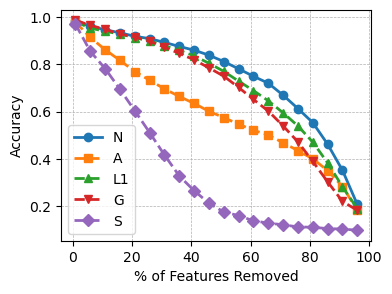

In [145]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='N', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='A', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1.values()), label='L1', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global.values()), label='G', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_structured.values()), label='S', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LeNet_FMNIST_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [137]:
result_normal_ig = filter_and_compute_road_saliency_ig(model, test_dataloader,"IntegratedGradients", device)

In [138]:
result_adv_ig = filter_and_compute_road_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)

In [139]:
result_l1_ig = filter_and_compute_road_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)

In [140]:
result_global_ig = filter_and_compute_road_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)

In [141]:
result_structured_ig = filter_and_compute_road_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)

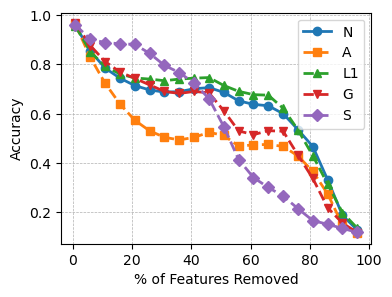

In [143]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal_ig.keys()),list(result_normal_ig.values()), label='N', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_adv_ig.values()), label='A', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_l1_ig.values()), label='L1', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_global_ig.values()), label='G', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_structured_ig.values()), label='S', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LeNet_FMNIST_IG_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [54]:
def filter_and_compute_road_smooth(model, test_loader, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                },
        )
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 1000:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts

    # Display the average values
    # print("Average Values:")
    # for key, value in average_values.items():
    #     print(f"{key}: {value}")
    return average_values

In [55]:
result_normal_smooth = filter_and_compute_road_smooth(model, test_dataloader, device)

In [56]:
result_adv_smooth = filter_and_compute_road_smooth(model_adv, test_dataloader, device)

In [57]:
result_l1_smooth = filter_and_compute_road_smooth(model_l1_unstructured, test_dataloader, device)

In [58]:
result_global_smooth = filter_and_compute_road_smooth(model_global, test_dataloader, device)

In [59]:
result_structured_smooth = filter_and_compute_road_smooth(model_structured, test_dataloader, device)

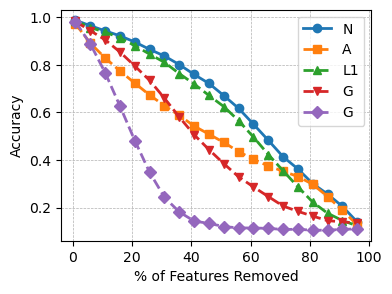

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal_smooth.keys()),list(result_normal_smooth.values()), label='N', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_adv_smooth.values()), label='A', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_l1_smooth.values()), label='L1', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_global_smooth.values()), label='G', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_structured_smooth.values()), label='S', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("LeNet_FMNIST_SMOOTH_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [147]:
import math
def filter_and_compute_input_stability_saliency_ig(model, test_loader,method, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": method, "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [160]:
normal_input_saliency = filter_and_compute_input_stability_saliency_ig(model, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", normal_input_saliency)

The relative input stability score is:  5.066674427418179


In [161]:
adversarial_input_saliency = filter_and_compute_input_stability_saliency_ig(model_adv, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", adversarial_input_saliency)

The relative input stability score is:  4.225695502027566


In [162]:
l1_input_saliency =  filter_and_compute_input_stability_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", l1_input_saliency)

The relative input stability score is:  4.573288190834013


In [163]:
global_input_saliency = filter_and_compute_input_stability_saliency_ig(model_global, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", global_input_saliency)

The relative input stability score is:  4.160707619092476


In [164]:
layered_input_saliency = filter_and_compute_input_stability_saliency_ig(model_structured, test_dataloader,"Saliency", device)
print("The relative input stability score is: ", layered_input_saliency)

The relative input stability score is:  5.016785834655409


In [165]:
normal_input_ig  = filter_and_compute_input_stability_saliency_ig(model, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", normal_input_ig)

The relative input stability score is:  5.8216689413066165


In [166]:
adversarial_input_ig = filter_and_compute_input_stability_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", adversarial_input_ig)

The relative input stability score is:  4.316235615069907


In [167]:
l1_input_ig = filter_and_compute_input_stability_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ",l1_input_ig)

The relative input stability score is:  3.758161243759267


In [168]:
global_input_ig = filter_and_compute_input_stability_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", global_input_ig)

The relative input stability score is:  0.5750025243673051


In [169]:
layered_input_ig = filter_and_compute_input_stability_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)
print("The relative input stability score is: ", layered_input_ig)

The relative input stability score is:  6.18274377011576


In [180]:
import math
def filter_and_compute_input_stability_smooth(model, test_loader, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [182]:
normal_input_smooth  =  filter_and_compute_input_stability_smooth(model, test_dataloader, device)
print("The relative input stability score is: ",normal_input_smooth)

The relative input stability score is:  -2.2871881059388004


In [183]:
adversarial_input_smooth =  filter_and_compute_input_stability_smooth(model_adv, test_dataloader, device)
print("The relative input stability score is: ",adversarial_input_smooth)

The relative input stability score is:  -1.7823288032721591


In [184]:
l1_input_smooth = filter_and_compute_input_stability_smooth(model_l1_unstructured, test_dataloader, device)
print("The relative input stability score is: ", l1_input_smooth)

The relative input stability score is:  -2.0172942618764056


In [185]:
global_input_smooth = filter_and_compute_input_stability_smooth(model_global, test_dataloader, device)
print("The relative input stability score is: ", global_input_smooth)

The relative input stability score is:  -2.274979903117145


In [186]:
layered_input_smooth = filter_and_compute_input_stability_smooth(model_structured, test_dataloader, device)
print("The relative input stability score is: ", layered_input_smooth)

The relative input stability score is:  0.7478442923747064


In [200]:
vanilla_gradient = [normal_input_saliency, adversarial_input_saliency, l1_input_saliency, global_input_saliency, layered_input_saliency]
integrated_gradients = [normal_input_ig, adversarial_input_ig, l1_input_ig, global_input_ig, layered_input_ig]
smoothgrad = [normal_input_smooth, adversarial_input_smooth, l1_input_smooth, global_input_smooth, layered_input_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,5.066674,5.821669,-2.287188
Adversarial Model,4.225696,4.316236,-1.782329
L1 Unstructured Pruned,4.573288,3.758161,-2.017294
Global Pruned,4.160708,0.575003,-2.274980
Layered Structured Pruned,5.016786,6.182744,0.747844


In [83]:
import math
def filter_and_compute_output_stability_saliency_ig(model, test_loader,method,  device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": method, "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [85]:
normal_output_saliency = filter_and_compute_output_stability_saliency_ig(model, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", normal_output_saliency)

The relative output stability score is:  10.248388393518342


In [86]:
adversarial_output_saliency = filter_and_compute_output_stability_saliency_ig(model_adv, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", adversarial_output_saliency)

The relative output stability score is:  10.491200766763761


In [87]:
l1_output_saliency = filter_and_compute_output_stability_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", l1_output_saliency)

The relative output stability score is:  9.54433600676578


In [88]:
global_output_saliency = filter_and_compute_output_stability_saliency_ig(model_global, test_dataloader,"Saliency", device)
print("The relative output stability score is: ", global_output_saliency)

The relative output stability score is:  9.571688178130827


In [89]:
layered_output_saliency = filter_and_compute_output_stability_saliency_ig(model_structured, test_dataloader,"Saliency", device)
print("The relative output stability score is: ",layered_output_saliency )

The relative output stability score is:  9.854424967881346


In [90]:
normal_output_ig = filter_and_compute_output_stability_saliency_ig(model, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ", normal_output_ig)

The relative output stability score is:  9.709989289948878


In [91]:
adversarial_output_ig = filter_and_compute_output_stability_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ", adversarial_output_ig)

The relative output stability score is:  10.638913475367135


In [92]:
l1_output_ig =  filter_and_compute_output_stability_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ",l1_output_ig)

The relative output stability score is:  9.753132148435613


In [93]:
global_output_ig = filter_and_compute_output_stability_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ",global_output_ig )

The relative output stability score is:  5.500438286338631


In [94]:
layered_output_ig = filter_and_compute_output_stability_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)
print("The relative output stability score is: ", layered_output_ig)

The relative output stability score is:  11.408792743159324


In [95]:
def filter_and_compute_output_stability_smooth(model, test_loader, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [96]:
normal_output_smooth =  filter_and_compute_output_stability_smooth(model, test_dataloader, device)
print("The relative output stability score is: ",normal_output_smooth)

The relative output stability score is:  2.834908317705301


In [97]:
adversarial_output_smooth =  filter_and_compute_output_stability_smooth(model_adv, test_dataloader, device)
print("The relative output stability score is: ",adversarial_output_smooth)

The relative output stability score is:  4.275068269353544


In [98]:
l1_output_smooth = filter_and_compute_output_stability_smooth(model_l1_unstructured, test_dataloader, device)
print("The relative output stability score is: ", l1_output_smooth)

The relative output stability score is:  3.192582269842001


In [99]:
global_output_smooth = filter_and_compute_output_stability_smooth(model_global, test_dataloader, device)
print("The relative output stability score is: ", global_output_smooth)

The relative output stability score is:  2.9948924785089353


In [100]:
layered_output_smooth = filter_and_compute_output_stability_smooth(model_structured, test_dataloader, device)
print("The relative output stability score is: ", layered_output_smooth)

The relative output stability score is:  10.246903949706216


In [101]:
vanilla_gradient = [normal_output_saliency, adversarial_output_saliency, l1_output_saliency, global_output_saliency, layered_output_saliency]
integrated_gradients = [normal_output_ig, adversarial_output_ig, l1_output_ig, global_output_ig, layered_output_ig]
smoothgrad = [normal_output_smooth, adversarial_output_smooth, l1_output_smooth, global_output_smooth, layered_output_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,10.248388,9.709989,2.834908
Adversarial Model,10.491201,10.638913,4.275068
L1 Unstructured Pruned,9.544336,9.753132,3.192582
Global Pruned,9.571688,5.500438,2.994892
Layered Structured Pruned,9.854425,11.408793,10.246904


In [121]:
def filter_and_compute_sparsity_saliency_ig(model, test_loader,method,  device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": method, "softmax": False})
        score_sparsity.extend(scores)
        if len(score_sparsity) > 1000:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [123]:
normal_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model, test_dataloader,"Saliency", device)
print("The sparsity score is: ", normal_sparse_saliency)

The sparsity score is:  (0.5353929176789969, 0.0037229877908571333)


In [124]:
adversarial_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_adv, test_dataloader,"Saliency", device)
print("The sparsity score is: ", adversarial_sparse_saliency)

The sparsity score is:  (0.567786553556568, 0.005803276710414247)


In [125]:
l1_sparse_saliency =  filter_and_compute_sparsity_saliency_ig(model_l1_unstructured, test_dataloader,"Saliency", device)
print("The sparsity score is: ",l1_sparse_saliency)

The sparsity score is:  (0.545625553741832, 0.004213131618629125)


In [126]:
global_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_global, test_dataloader,"Saliency", device)
print("The sparsity score is: ", global_sparse_saliency)

The sparsity score is:  (0.6036586866658717, 0.007687796444217604)


In [127]:
layered_sparse_saliency = filter_and_compute_sparsity_saliency_ig(model_structured, test_dataloader,"Saliency", device)
print("The sparsity score is: ",layered_sparse_saliency  )

The sparsity score is:  (0.7910504827975011, 0.009565304980180553)


In [128]:
normal_sparse_ig =  filter_and_compute_sparsity_saliency_ig(model, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ",normal_sparse_ig)

The sparsity score is:  (0.7729951314646315, 0.014269488272607404)


In [129]:
adversarial_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_adv, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ",adversarial_sparse_ig )

The sparsity score is:  (0.773559511057318, 0.014989847356781468)


In [130]:
l1_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_l1_unstructured, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ", l1_sparse_ig)

The sparsity score is:  (0.7720026135998528, 0.01552885635228196)


In [131]:
global_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_global, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ",global_sparse_ig )

The sparsity score is:  (0.7674200542197189, 0.0146018313506834)


In [132]:
layered_sparse_ig = filter_and_compute_sparsity_saliency_ig(model_structured, test_dataloader,"IntegratedGradients", device)
print("The sparsity score is: ", layered_sparse_ig)

The sparsity score is:  (0.850306168389013, 0.010784806913349557)


In [133]:
def filter_and_compute_sparsity_smooth(model, test_loader, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                 explain_func= explainer_wrapper,
                explain_func_kwargs = {
                    "method": xai_method[0],
                    "posterior_mean": copy.deepcopy(
                        model
                        .to(device)
                        .state_dict()
                    ),
                    "mean": 1.0,
                    "std": 0.5,
                    "n": 25,
                    "device": device,
                })
        score_sparsity.extend(scores)
        if len(score_sparsity) > 1000:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [135]:
normal_sparse_smooth = filter_and_compute_sparsity_smooth(model, test_dataloader, device)
print("The sparsity score is: ",normal_sparse_smooth )

The sparsity score is:  (0.34745736041242725, 0.0043840386908674985)


In [136]:
adversarial_sparse_smooth = filter_and_compute_sparsity_smooth(model_adv, test_dataloader, device)
print("The sparsity score is: ", adversarial_sparse_smooth)

The sparsity score is:  (0.4228882196351659, 0.005825839358584965)


In [137]:
l1_sparse_smooth = filter_and_compute_sparsity_smooth(model_l1_unstructured, test_dataloader, device)
print("The sparsity score is: ", l1_sparse_smooth)

The sparsity score is:  (0.35473342218460663, 0.004543606507123993)


In [138]:
global_sparse_smooth = filter_and_compute_sparsity_smooth(model_global, test_dataloader, device)
print("The sparsity score is: ", global_sparse_smooth)

The sparsity score is:  (0.418018706893464, 0.008366724387788765)


In [139]:
layered_sparse_smooth =  filter_and_compute_sparsity_smooth(model_structured, test_dataloader, device)
print("The sparsity score is: ",layered_sparse_smooth)

The sparsity score is:  (0.6249091006791578, 0.008828304940229424)


In [140]:
vanilla_gradient = [normal_sparse_saliency, adversarial_sparse_saliency, l1_sparse_saliency, global_sparse_saliency, layered_sparse_saliency]
integrated_gradients = [normal_sparse_ig, adversarial_sparse_ig, l1_sparse_ig, global_sparse_ig, layered_sparse_ig]
smoothgrad = [normal_sparse_smooth, adversarial_sparse_smooth, l1_sparse_smooth, global_sparse_smooth, layered_sparse_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,"(0.5353929176789969, 0.0037229877908571333)","(0.7729951314646315, 0.014269488272607404)","(0.34745736041242725, 0.0043840386908674985)"
Adversarial Model,"(0.567786553556568, 0.005803276710414247)","(0.773559511057318, 0.014989847356781468)","(0.4228882196351659, 0.005825839358584965)"
L1 Unstructured Pruned,"(0.545625553741832, 0.004213131618629125)","(0.7720026135998528, 0.01552885635228196)","(0.35473342218460663, 0.004543606507123993)"
Global Pruned,"(0.6036586866658717, 0.007687796444217604)","(0.7674200542197189, 0.0146018313506834)","(0.418018706893464, 0.008366724387788765)"
Layered Structured Pruned,"(0.7910504827975011, 0.009565304980180553)","(0.850306168389013, 0.010784806913349557)","(0.6249091006791578, 0.008828304940229424)"
